### Developing a phylogenetic tree for the used oligonucletide data in this work

This notebook facilitates the implementation of a phylogenetic tree using the processed sequence in this work. For this, the following steps are implemented:

- Read processed sequence in this work
- Make a query to Blast for identifying candidates for a multi alignment sequence process
- Filter candidates based on stablished criteria
- Run a multi alignment sequence
- Process the MSA and prepare data for the development of a phylogenetic tree
- Generate a phylogenetic tree
- Plot phylogenetic tree and save the results

- Process warning

In [1]:
import warnings
warnings.filterwarnings('ignore')

- Load modules

In [2]:
from Bio.Blast import NCBIWWW, NCBIXML
from Bio.Align.Applications import ClustalOmegaCommandline
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor
import matplotlib.pyplot as plt
from Bio import SeqIO, Entrez, AlignIO, Phylo
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
import pandas as pd
import seaborn as sns
import os
import re

- Auxiliar functions

In [3]:
def apply_process_to_name(title):

    values = title.split("|")
    names = values[-1]
    names = names.strip()
    names_list = names.split(" ")
    name_data = f"{names_list[0]} {names_list[1]}"
    return name_data

In [4]:
def get_gi(title):
    values = title.split("|")
    gi_id = f"{values[0]}|{values[1]}"
    return gi_id

In [5]:
def get_additional_id(title):
    values = title.split("|")
    additional_id = f"{values[2]}|{values[3]}"
    return additional_id

In [6]:
def check_entres_to_ignore(title):
    if "PREDICTED" in title or "cultured" in title or "Cloning" in title or "Synthetic construct" in title or "Homo sapiens" in title:
        return True
    else:
        return False

In [7]:
def recover_full_sequence(title):
    
    try:
        Entrez.email = "david.medina@cebib.cl"

        accession = re.search(r"\|([A-Z_]+\d+\.\d+)\|", title)
        if accession:
            acc = accession.group(1)

            # Descargar la secuencia completa
            handle = Entrez.efetch(db="nucleotide", id=acc, rettype="fasta", retmode="text")
            record = SeqIO.read(handle, "fasta")
            return str(record.seq)
        else:
            return "seq not found"
    except:
        return "seq not found"

- Load input sequence

In [8]:
for record in SeqIO.parse("../raw_data_giannina/oligos_sequences.fasta", "fasta"):
    sequences_to_process = {
        "Organism" : record.description,
        "Sequence" : str(record.seq)
    }

sequences_to_process

{'Organism': 'Study Argopecten purpuratus',
 'Sequence': 'TCAGTTCAACAGTGTTTGGGCATGAGTCTCTACAATGTACTGGTGGTATTGTTTTAGCAGGTGATGCATTTGTTCTACTTCTTCACTGACTAGTGTTTTCACAAAGAATTTCTTATCCTGAGACATCAACATCCGGGCCCCACTCCGGCCGGGGGAGTCTACATCCAACGCCTGCTTAGTTAAGGAGTTCATATAATCTTGGTCATCGATTCCGAATCTCTCCCGGAGATTCCTGAACACAACTGGGCAATACTCCTTACCTTGAAATGACTTGGCATACTTTCTTTGTTGTAAGAATGATTGTCCACTCGTACTTTACTGAACGCTTTAAAATCATCGGGCATCAACATTACAGGAAGGTTCACATGGTTCAAGCCATTTATCGTATGATTAATCCCCCACCAATGACATCTAGAGAATCACTAGTGAATTCGCGGCCGCCTGCAGGTCGACCATATGGGAGAGCTCCCAACGCGTTGGATGCATA'}

- Making query to NCBI-BLAST for alignment sequences

In [9]:
query_seq = Seq(sequences_to_process["Sequence"])
record = SeqRecord(query_seq, id="Query1", description=sequences_to_process["Organism"])

print("Sending BLAST query to NCBI...")
result_handle = NCBIWWW.qblast(
    program="blastn",             
    database="nt",                
    sequence=record.format("fasta"),
    hitlist_size=10000,              
    format_type="XML"
)

blast_records = NCBIXML.read(result_handle)

filter_sequences = []

for alignment in blast_records.alignments:
    hsp = alignment.hsps[0]  # high-scoring pair
    
    row = [
        alignment.title,
        hsp.score,
        hsp.sbjct,
        hsp.identities / hsp.align_length
    ]

    filter_sequences.append(row)

df_selected_sequences = pd.DataFrame(
    data=filter_sequences, 
    columns=["title", "score", "aligned_sequence", "identity"])

df_selected_sequences.head(5)

Sending BLAST query to NCBI...


,title,score,aligned_sequence,identity
0,gi|2835362640|ref|XM_069255312.1| PREDICTED: A...,735.0,CAACAATGTCTGGGCATGAGTCTCTACAATGTACTGGTGGTATTGT...,0.972292
1,gi|1835471732|ref|XR_004536138.1| PREDICTED: P...,625.0,CAGCAATGTCTGAGCATGAGTCTCTACAATGTACTGATGGTACTGT...,0.916877
2,gi|1835471729|ref|XR_004536137.1| PREDICTED: P...,625.0,CAGCAATGTCTGAGCATGAGTCTCTACAATGTACTGATGGTACTGT...,0.916877
3,gi|1835471725|ref|XM_033906951.1| PREDICTED: P...,625.0,CAGCAATGTCTGAGCATGAGTCTCTACAATGTACTGATGGTACTGT...,0.916877
4,gi|1207973896|ref|XM_021522106.1| PREDICTED: M...,581.0,GTCTGGGCATGAGTCTCTACAATGTACTGGTGGTACTGTTTGAGTA...,0.900000


- Removing PREDICTED/Uncultured elements

In [10]:
df_selected_sequences["to_ignore"] = df_selected_sequences["title"].apply(check_entres_to_ignore)
df_selected_sequences["to_ignore"].value_counts()
df_filter_sequences = df_selected_sequences[df_selected_sequences["to_ignore"]==False]
df_filter_sequences.head(5)

,title,score,aligned_sequence,identity,to_ignore
26,gi|2671790432|gb|PP199098.1| Argopecten irradi...,267.0,CTGGTGGTATTGTTTAAGCAGGTGATGCATCTGTTCTACTTCTTCA...,0.953642,False
35,gi|2277725323|gb|MW800702.1| Octopus vulgaris ...,214.0,AACAACGTCTGTGCGTGTCTTTCAACAATATATGAGTGATACTGTT...,0.717500,False
44,gi|2254959558|gb|OM296289.1| Androctonus crass...,189.0,TGTTTTTCCATGACATTCCACAATATAAGGATGATACTGTTTGAGT...,0.702771,False
86,gi|2099394798|ref|NM_001030971.2| Gallus gallu...,174.0,CATGACACTCCACAATAAACTGATGGTATTTCTTCAGTATGTTGTG...,0.698454,False
91,gi|60099194|emb|AJ851794.1| Gallus gallus mRNA...,174.0,CATGACACTCCACAATAAACTGATGGTATTTCTTCAGTATGTTGTG...,0.698454,False


- Get names and IDs

In [11]:
df_filter_sequences["organism"] = df_filter_sequences["title"].apply(apply_process_to_name)
df_filter_sequences["gi"] = df_filter_sequences["title"].apply(get_gi)
df_filter_sequences["additionl_id"] = df_filter_sequences["title"].apply(get_additional_id)
df_filter_sequences.head(5)

,title,score,aligned_sequence,identity,to_ignore,organism,gi,additionl_id
26,gi|2671790432|gb|PP199098.1| Argopecten irradi...,267.0,CTGGTGGTATTGTTTAAGCAGGTGATGCATCTGTTCTACTTCTTCA...,0.953642,False,Argopecten irradians,gi|2671790432,gb|PP199098.1
35,gi|2277725323|gb|MW800702.1| Octopus vulgaris ...,214.0,AACAACGTCTGTGCGTGTCTTTCAACAATATATGAGTGATACTGTT...,0.717500,False,Octopus vulgaris,gi|2277725323,gb|MW800702.1
44,gi|2254959558|gb|OM296289.1| Androctonus crass...,189.0,TGTTTTTCCATGACATTCCACAATATAAGGATGATACTGTTTGAGT...,0.702771,False,Androctonus crassicauda,gi|2254959558,gb|OM296289.1
86,gi|2099394798|ref|NM_001030971.2| Gallus gallu...,174.0,CATGACACTCCACAATAAACTGATGGTATTTCTTCAGTATGTTGTG...,0.698454,False,Gallus gallus,gi|2099394798,ref|NM_001030971.2
91,gi|60099194|emb|AJ851794.1| Gallus gallus mRNA...,174.0,CATGACACTCCACAATAAACTGATGGTATTTCTTCAGTATGTTGTG...,0.698454,False,Gallus gallus,gi|60099194,emb|AJ851794.1


In [12]:
df_filter_sequences["organism"].value_counts()

Bacillus cereus                  66
Methylocella palustris           64
Bacillus thuringiensis           37
Pennisetum glaucum               33
Mus musculus                     33
                                 ..
Raphanus sativus                  1
Phytophthora cinnamomi            1
Musa balbisiana                   1
Stenotrophomonas chelatiphaga     1
PGeneClip Hygromycin              1
Name: organism, Length: 477, dtype: int64

- Checking duplicated entries. Including organisms and sequences

In [13]:
name_cound = df_filter_sequences.groupby(by="organism").count().sort_values(by="title", ascending=False)
unique_names = name_cound[name_cound["title"]==1]
duplicated_names = name_cound[name_cound["title"]>1]

print(unique_names.shape, duplicated_names.shape)

(317, 7) (160, 7)


In [14]:
filter_unique_names = df_filter_sequences[df_filter_sequences["organism"].isin(unique_names.index)]
filter_unique_names.shape

(317, 8)

In [20]:
filter_unique_names.columns

Index(['title', 'score', 'aligned_sequence', 'identity', 'to_ignore',
       'organism', 'gi', 'additionl_id'],
      dtype='object')

In [21]:
matrix_duplicated = []
for organism in duplicated_names.index:
    records_in_df = df_filter_sequences[df_filter_sequences["organism"] == organism]
    records_in_df.reset_index(inplace=True)
        
    row = []

    for column in ['title', 'score', 'aligned_sequence', 'identity', 'to_ignore', 'organism', 'gi', 'additionl_id']:
        row.append(records_in_df[column][0])
    
    matrix_duplicated.append(row)

df_selected_duplicated = pd.DataFrame(data=matrix_duplicated, columns=filter_unique_names.columns)
df_selected_duplicated

,title,score,aligned_sequence,identity,to_ignore,organism,gi,additionl_id
0,gi|939460503|emb|LN890238.1| Bacillus cereus p...,140.0,AATCACTAGTGAATTCGCGGCCGCCTGCAGGTCGACCATATGGGAG...,1.000000,False,Bacillus cereus,gi|939460503,emb|LN890238.1
1,gi|1313712470|emb|LT934184.1| Methylocella pal...,140.0,AATCACTAGTGAATTCGCGGCCGCCTGCAGGTCGACCATATGGGAG...,1.000000,False,Methylocella palustris,gi|1313712470,emb|LT934184.1
2,gi|939460295|emb|LN890030.1| Bacillus thuringi...,140.0,AATCACTAGTGAATTCGCGGCCGCCTGCAGGTCGACCATATGGGAG...,1.000000,False,Bacillus thuringiensis,gi|939460295,emb|LN890030.1
3,gi|259048771|emb|FN552482.1| Pennisetum glaucu...,142.0,GAATCACTAGTGAATTCGCGGCCGCCTGCAGGTCGACCATATGGGA...,1.000000,False,Pennisetum glaucum,gi|259048771,emb|FN552482.1
4,gi|3062783|dbj|AB009615.1| Mus musculus mRNA f...,155.0,CATGACATTCCACTATATACTGGTGGTACTTCTTCAGGATGTTGTG...,0.684755,False,Mus musculus,gi|3062783,dbj|AB009615.1
...,...,...,...,...,...,...,...,...
155,gi|226442392|dbj|AB495008.1| Xylaria sp. TI070...,116.0,GAATCACTAGTGAATTCGCGGCCGCCTGCAGGTCGACCATATGGGA...,1.000000,False,Xylaria sp.,gi|226442392,dbj|AB495008.1
156,gi|2917605509|emb|OZ228683.1| Sitta europaea g...,76.0,TAGTCCTGGTCATCGATGCCGAACCTCTCGCGCAGGTTCCGGAACA...,0.788235,False,Sitta europaea,gi|2917605509,emb|OZ228683.1
157,gi|651212704|gb|KJ586213.1| Carthamus tinctori...,67.0,AATTGTCGGCCGCCTG-AGGTCGACCATATGGGAAAGCT-CAAACG...,0.872727,False,Carthamus tinctorius,gi|651212704,gb|KJ586213.1
158,gi|449042857|gb|JX070071.1| Smilax brasiliensi...,85.0,AGAGAAATCCCTAGTGGAATTCGCGGGCCGCCTGCAAGGTCGACCA...,0.867470,False,Smilax brasiliensis,gi|449042857,gb|JX070071.1


In [22]:
processed_df = pd.concat([filter_unique_names, df_selected_duplicated], axis=0)
processed_df.reset_index(inplace=True)
processed_df = processed_df.drop(columns=["index"])
processed_df.shape

(477, 8)

In [23]:
processed_df["organism"].value_counts()

Argopecten irradians       1
PsiSTRIKE hMGFP            1
Bacteroidales bacterium    1
Arabidopsis lyrata         1
Arthrobacter ramosus       1
                          ..
Brugia malayi              1
Alteromonas sp.            1
Abra segmentum             1
Glomus sp.                 1
Lithodes maja              1
Name: organism, Length: 477, dtype: int64

- Get full sequences

In [ ]:
processed_df["full_sequence"] = processed_df["title"].apply(recover_full_sequence)

In [ ]:
processed_df = processed_df[processed_df["full_sequence"] != "seq not found"]
processed_df.shape

(1174, 10)

In [ ]:
processed_df.head(5)

,title,score,aligned_sequence,identity,is_predicted,organism,gi,additionl_id,to_ignore,full_sequence
26,gi|2671790432|gb|PP199098.1| Argopecten irradi...,267.0,CTGGTGGTATTGTTTAAGCAGGTGATGCATCTGTTCTACTTCTTCA...,0.953642,False,Argopecten irradians,gi|2671790432,gb|PP199098.1,False,CCATCTTGGATGTTGAGAGGTGTTGCAGCGATAATGGACCGTCTAC...
35,gi|2277725323|gb|MW800702.1| Octopus vulgaris ...,214.0,AACAACGTCTGTGCGTGTCTTTCAACAATATATGAGTGATACTGTT...,0.717500,False,Octopus vulgaris,gi|2277725323,gb|MW800702.1,False,ATGGCTAGTGCCAAAAGGAAGCACCTTAAAATGAAAACTGTCCAAC...
44,gi|2254959558|gb|OM296289.1| Androctonus crass...,189.0,TGTTTTTCCATGACATTCCACAATATAAGGATGATACTGTTTGAGT...,0.702771,False,Androctonus crassicauda,gi|2254959558,gb|OM296289.1,False,TAATTACAAATTTGACCTCATAATTCGCAGTTTCATTTCATGACTG...
86,gi|2099394798|ref|NM_001030971.2| Gallus gallu...,174.0,CATGACACTCCACAATAAACTGATGGTATTTCTTCAGTATGTTGTG...,0.698454,False,Gallus gallus,gi|2099394798,ref|NM_001030971.2,False,GGCGCGGCAGAGGCCGGGATGCGCGCGGCGTCCCGCGGCAGTCAGT...
91,gi|60099194|emb|AJ851794.1| Gallus gallus mRNA...,174.0,CATGACACTCCACAATAAACTGATGGTATTTCTTCAGTATGTTGTG...,0.698454,False,Gallus gallus,gi|60099194,emb|AJ851794.1,False,GCCCCGCGGCGGGCGGGGCCGCGGCGCGCGAGCGGGGCCATTTCGG...


- Checking length

In [ ]:
processed_df["length"] = processed_df["full_sequence"].str.len()
processed_df["length"].describe()

count    4.760000e+02
mean     1.153260e+06
std      7.499127e+06
min      1.950000e+02
25%      6.985000e+02
50%      1.136500e+03
75%      1.687000e+03
max      8.829979e+07
Name: length, dtype: float64

In [ ]:
sns.histplot(data=processed_df, x="length", fill=False)

KeyboardInterrupt: 

- Checking identity distribution

<Axes: xlabel='identity', ylabel='Count'>

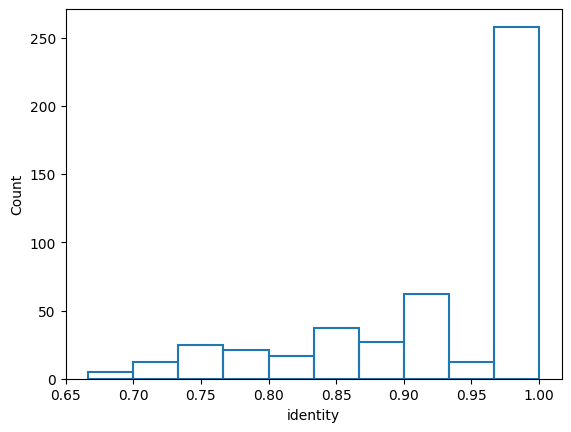

In [ ]:
sns.histplot(data=processed_df, x="identity", fill=False)

<Axes: xlabel='identity'>

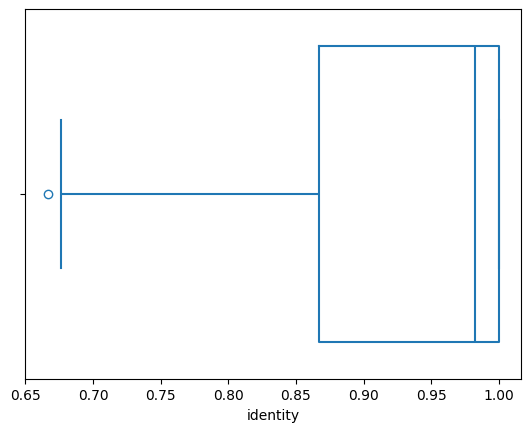

In [ ]:
sns.boxplot(data=processed_df, x="identity", fill=False)

In [ ]:
processed_df.describe()

,score,identity
count,476.000000,476.000000
mean,103.707983,0.927362
std,33.309281,0.090178
min,50.000000,0.666667
25%,73.000000,0.867269
50%,108.000000,0.982299
75%,140.000000,1.000000
max,267.000000,1.000000


- Taking in consideration the statistics descriptors in terms of quantiles, there are no enough information to apply any outlier detector method. Based on this, we will filter for all organisms that has more than 0.95 of identity 

In [ ]:
processed_df["is_for_tree"] = (processed_df["identity"]>=0.95).astype(int)
processed_df["is_for_tree"].value_counts()

1    264
0    212
Name: is_for_tree, dtype: int64

In [ ]:
df_for_tree = processed_df[processed_df["is_for_tree"]==1]
df_for_tree.shape

(264, 11)

In [ ]:
df_for_tree.head(5)

,title,score,aligned_sequence,identity,is_predicted,organism,gi,additionl_id,to_ignore,full_sequence,is_for_tree
0,gi|2671790432|gb|PP199098.1| Argopecten irradi...,267.0,CTGGTGGTATTGTTTAAGCAGGTGATGCATCTGTTCTACTTCTTCA...,0.953642,False,Argopecten irradians,gi|2671790432,gb|PP199098.1,False,CCATCTTGGATGTTGAGAGGTGTTGCAGCGATAATGGACCGTCTAC...,1
6,gi|47600836|emb|AJ715983.1| Equus caballus mRN...,144.0,AGAATCACTAGTGAATTCGCGGCCGCCTGCAGGTCGACCATATGGG...,1.000000,False,Equus caballus,gi|47600836,emb|AJ715983.1,False,TTGCTATGCATCCAACGCGTTGGGAGCTCTCCCATATGGTCGACCT...,1
7,gi|333774853|emb|FR822395.1| Rhodotorula sp. C...,144.0,AGAATCACTAGTGAATTCGCGGCCGCCTGCAGGTCGACCATATGGG...,1.000000,False,Rhodotorula sp.,gi|333774853,emb|FR822395.1,False,CTATTTAGGTGACACTATAGAATACTCAAGCTATGCATCCAACGCG...,1
8,gi|333774854|emb|FR822396.1| Aspergillus sp. s...,144.0,AGAATCACTAGTGAATTCGCGGCCGCCTGCAGGTCGACCATATGGG...,1.000000,False,Aspergillus sp.,gi|333774854,emb|FR822396.1,False,ATACTCAAGCTATGCATCCAACGCGTTGGGAGCTCTCCCATATGGT...,1
9,gi|116175378|emb|AM407893.1| Pseudomonas aceph...,142.0,GAATCACTAGTGAATTCGCGGCCGCCTGCAGGTCGACCATATGGGA...,1.000000,False,Pseudomonas acephalitica,gi|116175378,emb|AM407893.1,False,ATATTCGACTCACTATAGGGCGAATTGGGCCCGACGTCTCATGCTC...,1


- Prepare a fasta file for generating the MSA

In [ ]:
fasta_file = "tmp.fasta"
records = [
    SeqRecord(Seq(seq), id=seq_id, description="")
    for seq_id, seq in zip(df_for_tree["organism"], df_for_tree["full_sequence"])
]

record_seq = SeqRecord(query_seq, id="Argopecten purpuratus", description="")

records.append(record_seq)

SeqIO.write(records, fasta_file, "fasta")

265

- Runing MSA